# GPU programming using PyOpenCL, part 3: Scatter

This is a set of exercises on the usage of PyOpenCL. There are 6 main classes of parallel algorithms:
1. Map or Element-wise kernels: 1 thread calculates 1 result from 1 input position
2. Gather: 1 thread calculates 1 result from several input data, one typical example is the convolution
3. Scatter: 1 thread uses 1 input element and scatters it on one or several output pixels, this requires the usage of atomic operarions
4. Reduction: Apply the same associative operation on all element of an ensemble, for example the sum of all elements in a list.
5. Scan: also called prefix sum, this algorithm applies the same associative operation to all *previous* elements of a list, for example a cummulative sum (cumsum)
6. Sort: using sorting network like the bitonic sort.

This third tutorial focuses on the **Scatter** operation where one thread is writing information in different memory locations.
While previously (in Map & Gather), the thread know it was the only one writting at a given position, here several threads are likely to write into the very same memory location at the same time, causing errors in the processing.
To prevent such error, the writing should be performed using an **atomic** operation.

There are 2 sections: an example of usage, followed by the direct application in an exercise to be done.

* Count the number of occurance of each letter in a text.
* Calculate the histogram of each color for an image

First we load some python modules to be able to read and display images. Then we initialize OpenCL, a context, a command queue, ...

In [1]:
from math import ceil
import numpy as np
import pyopencl as cl
from pyopencl import array as cla
ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

print(ctx.devices[0])

<pyopencl.Device 'NVIDIA RTX A5000' on 'NVIDIA CUDA' at 0x55f22e76e7b0>


In [2]:
filename = "OpenCL_API.html"
with open(filename) as f:
    txt = f.read()
txt = np.array([ord(i) for i in txt if ord(i)<256], "uint8")
print(len(txt))

2943334


In [3]:
letters_d = cla.zeros(queue, 256, "int32")
txt_d = cla.to_device(queue, txt)
%load_ext pyopencl.ipython_ext

In [4]:
%%cl_kernel
kernel void count(global uchar* txt, global int* letters){
    int idx = get_global_id(0);
    atomic_inc(&letters[txt[idx]]);
}

In [5]:
letters_d.fill(0)
evt = count(queue, txt.shape, None,
            txt_d.data, letters_d.data)
evt.wait()
assert np.allclose(np.bincount(txt), letters_d.get()[:234])
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms (GPU)")
%timeit np.bincount(txt)

Profile time: 1.678ms (GPU)
5.13 ms ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


One can play with the workgroup size for best performances ...

## Now it is your turn:

Write a kernel called *histogram* which calculates the histogram for the 3 channels of an image: red, green and blue.

Test this kernel and compare the results and performances with the reference implementation

Here is the reference test function in numpy:

In [6]:
from PIL import Image
from matplotlib.pyplot import subplots
img = np.array(Image.open("14h33m35-SM-N970U1.jpg"))
img_d = cla.to_device(queue, img)
R, G, B = img.reshape((-1,3)).T

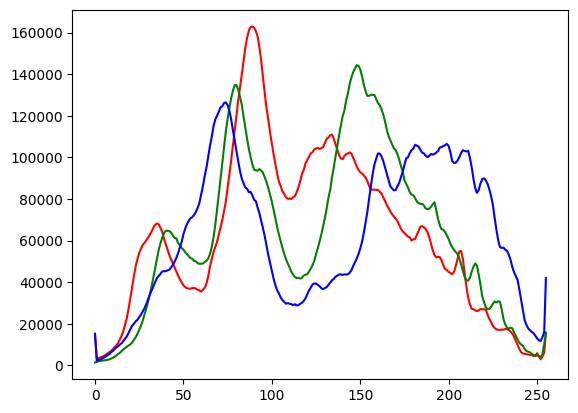

In [7]:
fig, ax = subplots()
ax.plot(np.bincount(R), color="r")
ax.plot(np.bincount(G), color="g")
ax.plot(np.bincount(B), color="b")

In [8]:
%%cl_kernel

UsageError: %%cl_kernel is a cell magic, but the cell body is empty.


In [ ]:
#call the kernel and test it, finally profile

## Some words of conclusion

It is important to protect the writing with atomic operatition when several threads are likely to write at the same location.

One can also perform atomic operation on shared memory (introduced in the section about Reduction), where it is faster and more efficient.


## Tips & tricks

Use an *atomic_dec* to know who is the latest workgroup finishing some task, in order to perform some clean-up without having to launch another kernel.